# This is exact same as `Final Caption Keras-Bidrectional-GRU-based sentiment analysis of OASIS dataset captions` notebook

Only without class weights

In [1]:
import os, sys, io,re, string, pathlib, random
from collections import Counter, OrderedDict

import hecutils.data_utils as dt
import hecutils.scoring_utils as sc
import hecutils.plotting_utils as pt
import hecutils.caption_utils as caput
import hecutils.image_utils as imut


import tensorflow as tf
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.layers import Dense, Conv1D, MaxPooling1D, GRU, Bidirectional, LSTM
from keras.layers.core import Dropout, Flatten, Masking, ActivityRegularization
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.utils import plot_model
from keras import regularizers
from keras.preprocessing import text
from keras.layers.embeddings import Embedding

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.utils import shuffle, class_weight
from sklearn.model_selection import StratifiedKFold, train_test_split

import numpy as np
import pandas as pd


from gensim.models import word2vec
from gensim.models.keyedvectors import KeyedVectors

import matplotlib.pyplot as plt
import time

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline

None


Using TensorFlow backend.


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

num_cores = 8
GPU=True
CPU = not GPU

if GPU:
    num_GPU = 1
    num_CPU = 8
if CPU:
    num_CPU = 8
    num_GPU = 0

config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})
session = tf.Session(config=config)
K.set_session(session)

In [3]:
# fix random seed for reproducibility
seed = 7

oasis_csv_path = "dataset/metadata/OASIS.csv"
captions_root = "/home/elkhand/git-repos/human-emotions-classifier/dataset/metadata"
captions_root_path = pathlib.Path(captions_root)
human_output_caption_to_label_csv_path = captions_root_path/'humanCaptionWithLabeldf2.csv'
human_caption_csv_path = captions_root_path/'captions.csv'
#fasttext_embedding_path = 'embedding/wiki-news-300d-1M.vec'
fasttext_embedding_path = '/home/elkhand/datasets/glove-vectors/glove.twitter.27B.200d.txt'
model_results_root_dir = "model2/"
inputDataset_csv_path = captions_root_path/"inputDataset2.csv"
testDataset_csv_path = captions_root_path/"testDataset2.csv"

neutralLow = 3.0 
neutralHigh = 5.0

auto_output_caption_to_label_csv_path = captions_root_path/'autoCaptionWithLabeldf2.csv'
auto_caption_csv_path = captions_root_path/'auto_generated_captions.csv'


dataset_path = human_output_caption_to_label_csv_path
#dataset_path = auto_output_caption_to_label_csv_path

kfold_splits = 10 
test_size = 0.1

embedding_dimension = 200 # 300
batch_size = 16 
nb_epochs = 100
dropout = 0.3 
recurrent_dropout=  0.5 
patience = 10
verbose = 1

useF1Score = True # True

## Original: separating data into test and input

In [4]:
# dt.create_caption_to_label(oasis_csv_path,human_caption_csv_path, human_output_caption_to_label_csv_path,neutralLow, neutralHigh)
# dt.create_caption_to_label(oasis_csv_path,auto_caption_csv_path, auto_output_caption_to_label_csv_path,neutralLow, neutralHigh)

# df = pd.read_csv(dataset_path, header=0, sep="|")
# df["caption"] = df["caption"].apply(lambda x: " ".join(caput.get_words_withoutstopwords(x.lower().split())))
# df["label"] = df["label"].apply(lambda x: caput.change_label_str_to_int(x))



# input_x, test_x, input_y,  test_y = train_test_split(df["caption"],
#                                                      df["label"],
#                                                      test_size=test_size,
#                                                      random_state=seed,
#                                                      stratify=df["label"])

# inputDataset = pd.concat([input_x, input_y], axis=1)
# testDataset = pd.concat([test_x, test_y], axis=1)

# inputDataset = inputDataset.dropna()
# testDataset = testDataset.dropna()
# inputDataset = inputDataset.reset_index()
# testDataset = testDataset.reset_index()


# inputDataset.to_csv(inputDataset_csv_path, index=False, sep="|")
# testDataset.to_csv(testDataset_csv_path, index=False, sep="|")

# print("df.head()\n", df.head())
# print("\n")
# print("df.tail()\n", df.tail())
# print("\n")
# print("inputDataset.head()\n", inputDataset.head())
# print("testDataset.head()\n", testDataset.head())
# print("\n")
# print("Label distribution in inputDataset", inputDataset.groupby('label').label.count())
# print("Label distribution in testDataset", testDataset.groupby('label').label.count())

## Common way of separating data into input and test

### Divide data into train/val/test datasets

Read dataframe to have:

<imageName, caption, label>

1. Read into df <imageId, label>
2. Then separate data into input and test datasets

In [5]:
dt.create_caption_to_label(oasis_csv_path,human_caption_csv_path, human_output_caption_to_label_csv_path,neutralLow, neutralHigh)
dt.create_caption_to_label(oasis_csv_path,auto_caption_csv_path, auto_output_caption_to_label_csv_path,neutralLow, neutralHigh)

dfImageIdCaptionLabel = pd.read_csv(dataset_path, header=0, sep="|")
dfImageIdCaptionLabel.columns = ["id","caption", "label"]
dfImageIdCaptionLabel["caption"] = dfImageIdCaptionLabel["caption"].apply(lambda x: " ".join(caput.get_words_withoutstopwords(x.lower().split())))
#dfImageIdCaptionLabel["label"] = dfImageIdCaptionLabel["label"].apply(lambda x: caput.change_label_str_to_int(x))


dfImageIdImageName = dt.get_image_id_to_image_title_as_df(oasis_csv_path)
dfImageIdImageName.columns = ['id', 'image_name']
dfImageIdImageName['image_name'] = dfImageIdImageName['image_name'].apply(lambda x: x + ".jpg") 
printCnt = 5
# has [id, caption, label]
df = pd.merge(dfImageIdCaptionLabel, dfImageIdImageName, on="id")
df["label"] = df["label"].apply(lambda x: caput.change_label_str_to_int(x))
#print(df.head(printCnt))



input_x, test_x, input_y,  test_y = train_test_split(df["id"],
                                                     df["label"],
                                                     test_size=test_size,
                                                     random_state=seed,
                                                     stratify=df["label"])

inputDataset = pd.concat([input_x, input_y], axis=1)
testDataset = pd.concat([test_x, test_y], axis=1)



# print("inputDataset\n", inputDataset.head(10))
# print("testDataset\n", testDataset.head(10))

print("\n")
print("Label distribution in inputDataset", inputDataset.groupby('label').label.count())
print("Label distribution in testDataset", testDataset.groupby('label').label.count())


inputDataset = df.loc[df['id'].isin(inputDataset.id)]
testDataset = df.loc[df['id'].isin(testDataset.id)]


inputDataset = inputDataset.dropna()
testDataset = testDataset.dropna()
inputDataset = inputDataset.reset_index()
testDataset = testDataset.reset_index()

# print("inputData\n", inputData.head())
# print("testData\n", testData.head())

inputIds = set(inputDataset['id'].values)
testIds = set(testDataset['id'].values)

print("Input data size", len(inputIds))
print("Test data size", len(testIds))

for inputId in inputIds:
    if inputId in testIds:
        raise inputId + " inputId exists both in test and input dataset"
        
for testId in testIds:
    if testId in inputIds:
        raise testId + " testId exists both in test and input dataset"        

#inputDataset.head()
print("head:\n")
print(testDataset.head(10))
print("tail\n")
print(testDataset.tail(10))



Label distribution in inputDataset label
-1    147
 0    378
 1    285
Name: label, dtype: int64
Label distribution in testDataset label
-1    16
 0    42
 1    32
Name: label, dtype: int64
Input data size 810
Test data size 90
head:

   index    id                                            caption  label  \
0      1   I10  bar several bottles wine partially-filled wine...      0   
1      5  I103  smiling woman wearing orange top blue shorts, ...      1   
2      8  I106  three men two women dressed medieval costumes ...      1   
3     13  I110  three boys playing refugee camp tents behind t...      0   
4     14  I111  person wearing hat coat sunburned faced lookin...      0   
5     19  I116  blue car hood smashed side road people looking...     -1   
6     60  I153       group male workers, mostly children factory.      0   
7     79  I170  cup coffee heart shape made milk foam, saucer ...      1   
8     86  I177  leafless tree, covered snow. ground tree also ...      1   
9  

## Load Embeddings

In [6]:
def load_embedding(path):
    word2vec = {}
    with io.open(path, encoding="utf8") as f:
        for line in f:
            entries = line.rstrip().split(" ")
            word, entries = entries[0], entries[1:]
            word2vec[word] = np.array(entries).astype(np.float) # Convert String type to float
    print('embedding size : %d' % len(word2vec))
    print('embedding dimension : %s' % (word2vec['apple'].shape,))
    return word2vec
    
wordToVec = {}
wordToVec = load_embedding(fasttext_embedding_path)



embedding size : 1193514
embedding dimension : (200,)


config:
 {'kfold_splits': 10, 'batch_size': 16, 'embedding_dimension': 200, 'recurrent_dropout': 0.5, 'dropout': 0.3, 'nb_epochs': 100, 'useF1Score': True, 'verbose': 1, 'seed': 7}
# words:  1193514  word vector dimension 200
Label distribution:  label
-1    147
 0    378
 1    285
Name: label, dtype: int64
max_seq_len 38
train_indices[:5] [0 2 3 4 5] train_indices[-5:] [805 806 807 808 809]
val_indices[:5] [ 1  8  9 20 25] val_indices[-5:] [743 756 766 781 801]

                                             caption  label
0           two acorns lying ground next oak leaves.      0
2  man free fall attached blue bungee jumping app...      0
3  falling man attached bungee jumping apparatus....      0
4  man kneeling front tent two similar-looking gi...      1
5  group young students classroom knees hands fol...      0
class_to_index {0: 0, 1: 1, -1: 2}
index_to_class {0: 0, 1: 1, 2: -1}

TRAIN size: 728 	 VAL size: 82
Train label distribution:  label
-1    134
 0    336
 1    258
Name: l

728/728 [==============================] - 5s 7ms/step - loss: 0.6034 - acc: 0.7486 - f1: 0.7302 - recall: 0.6937 - precision: 0.7741 - val_loss: 0.7943 - val_acc: 0.6463 - val_f1: 0.6376 - val_recall: 0.6220 - val_precision: 0.6548
Epoch 27/100
728/728 [==============================] - 5s 7ms/step - loss: 0.5962 - acc: 0.7500 - f1: 0.7416 - recall: 0.7033 - precision: 0.7874 - val_loss: 0.7945 - val_acc: 0.6463 - val_f1: 0.6376 - val_recall: 0.6220 - val_precision: 0.6548

Epoch 00027: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
Epoch 28/100
728/728 [==============================] - 5s 7ms/step - loss: 0.5761 - acc: 0.7624 - f1: 0.7442 - recall: 0.7060 - precision: 0.7908 - val_loss: 0.7945 - val_acc: 0.6463 - val_f1: 0.6376 - val_recall: 0.6220 - val_precision: 0.6548
Epoch 29/100
728/728 [==============================] - 5s 7ms/step - loss: 0.6025 - acc: 0.7459 - f1: 0.7258 - recall: 0.6896 - precision: 0.7695 - val_loss: 0.7937 - val_acc: 0.6463 - val_f1: 

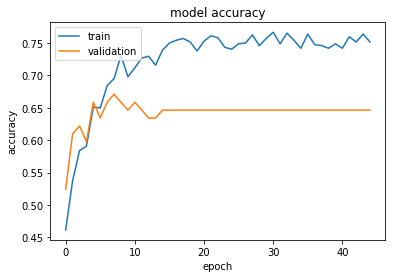

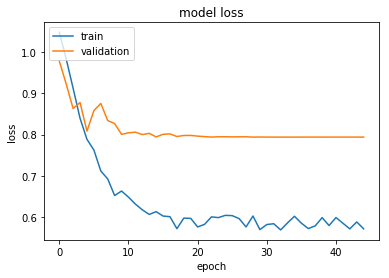

Time passed for training 239.80288219451904
train_indices[:5] [0 1 2 5 6] train_indices[-5:] [803 804 806 807 808]
val_indices[:5] [ 3  4 11 14 16] val_indices[-5:] [776 796 797 805 809]

                                             caption  label
0           two acorns lying ground next oak leaves.      0
1  ruined walls church backdrop white clouds blue...      0
2  man free fall attached blue bungee jumping app...      0
5  group young students classroom knees hands fol...      0
6  man boy playing board game camping site tablet...      1
class_to_index {0: 0, 1: 1, -1: 2}
index_to_class {0: 0, 1: 1, 2: -1}

TRAIN size: 728 	 VAL size: 82
Train label distribution:  label
-1    140
 0    342
 1    246
Name: label, dtype: int64
Val label distribution:  label
-1     7
 0    36
 1    39
Name: label, dtype: int64
Train on 728 samples, validate on 82 samples
Epoch 1/100
728/728 [==============================] - 6s 9ms/step - loss: 1.0507 - acc: 0.4409 - f1: 0.0904 - recall: 0.0618 - prec

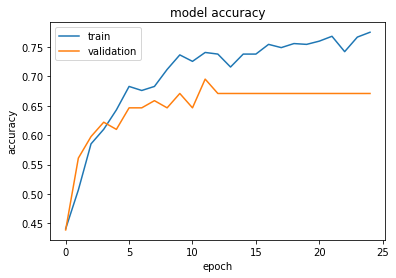

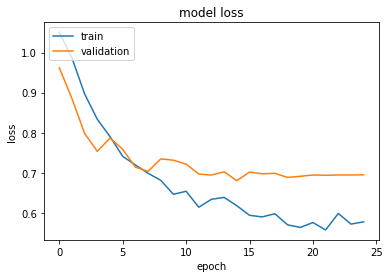

Time passed for training 133.53459358215332
train_indices[:5] [0 1 2 3 4] train_indices[-5:] [805 806 807 808 809]
val_indices[:5] [ 6  7 32 48 50] val_indices[-5:] [777 778 784 785 799]

                                             caption  label
0           two acorns lying ground next oak leaves.      0
1  ruined walls church backdrop white clouds blue...      0
2  man free fall attached blue bungee jumping app...      0
3  falling man attached bungee jumping apparatus....      0
4  man kneeling front tent two similar-looking gi...      1
class_to_index {0: 0, 1: 1, -1: 2}
index_to_class {0: 0, 1: 1, 2: -1}

TRAIN size: 728 	 VAL size: 82
Train label distribution:  label
-1    129
 0    344
 1    255
Name: label, dtype: int64
Val label distribution:  label
-1    18
 0    34
 1    30
Name: label, dtype: int64
Train on 728 samples, validate on 82 samples
Epoch 1/100
728/728 [==============================] - 6s 8ms/step - loss: 1.0515 - acc: 0.4341 - f1: 0.1087 - recall: 0.0687 - prec

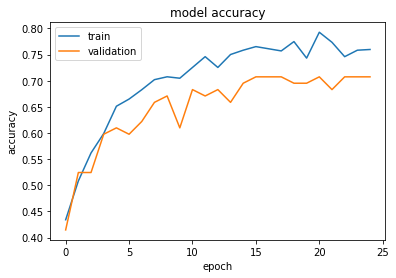

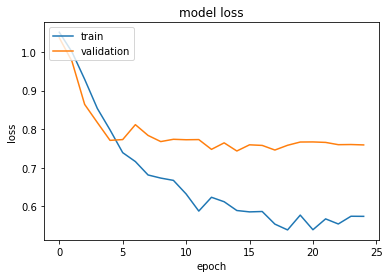

Time passed for training 133.46884870529175
train_indices[:5] [0 1 2 3 4] train_indices[-5:] [805 806 807 808 809]
val_indices[:5] [10 15 22 28 56] val_indices[-5:] [762 779 791 792 795]

                                             caption  label
0           two acorns lying ground next oak leaves.      0
1  ruined walls church backdrop white clouds blue...      0
2  man free fall attached blue bungee jumping app...      0
3  falling man attached bungee jumping apparatus....      0
4  man kneeling front tent two similar-looking gi...      1
class_to_index {0: 0, 1: 1, -1: 2}
index_to_class {0: 0, 1: 1, 2: -1}

TRAIN size: 728 	 VAL size: 82
Train label distribution:  label
-1    133
 0    334
 1    261
Name: label, dtype: int64
Val label distribution:  label
-1    14
 0    44
 1    24
Name: label, dtype: int64
Train on 728 samples, validate on 82 samples
Epoch 1/100
728/728 [==============================] - 6s 8ms/step - loss: 1.0451 - acc: 0.4382 - f1: 0.0498 - recall: 0.0288 - prec

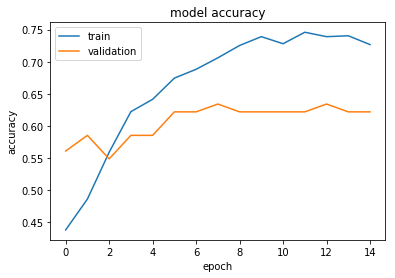

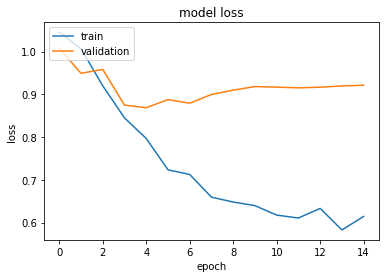

Time passed for training 83.66632771492004
train_indices[:5] [0 1 2 3 4] train_indices[-5:] [805 806 807 808 809]
val_indices[:5] [ 5 13 17 19 26] val_indices[-5:] [727 755 759 782 800]

                                             caption  label
0           two acorns lying ground next oak leaves.      0
1  ruined walls church backdrop white clouds blue...      0
2  man free fall attached blue bungee jumping app...      0
3  falling man attached bungee jumping apparatus....      0
4  man kneeling front tent two similar-looking gi...      1
class_to_index {0: 0, 1: 1, -1: 2}
index_to_class {0: 0, 1: 1, 2: -1}

TRAIN size: 728 	 VAL size: 82
Train label distribution:  label
-1    127
 0    345
 1    256
Name: label, dtype: int64
Val label distribution:  label
-1    20
 0    33
 1    29
Name: label, dtype: int64
Train on 728 samples, validate on 82 samples
Epoch 1/100
728/728 [==============================] - 6s 8ms/step - loss: 1.0236 - acc: 0.4629 - f1: 0.1373 - recall: 0.0852 - preci

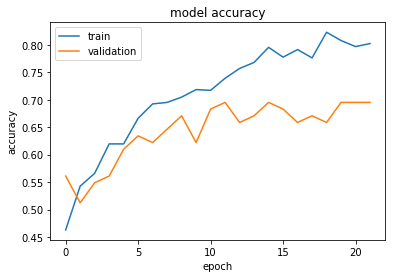

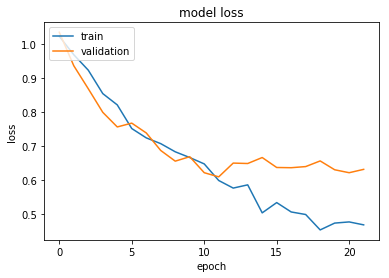

Time passed for training 118.74463033676147
train_indices[:5] [1 2 3 4 5] train_indices[-5:] [804 805 807 808 809]
val_indices[:5] [ 0 35 42 46 47] val_indices[-5:] [760 764 769 786 806]

                                             caption  label
1  ruined walls church backdrop white clouds blue...      0
2  man free fall attached blue bungee jumping app...      0
3  falling man attached bungee jumping apparatus....      0
4  man kneeling front tent two similar-looking gi...      1
5  group young students classroom knees hands fol...      0
class_to_index {0: 0, 1: 1, -1: 2}
index_to_class {0: 0, 1: 1, 2: -1}

TRAIN size: 729 	 VAL size: 81
Train label distribution:  label
-1    129
 0    337
 1    263
Name: label, dtype: int64
Val label distribution:  label
-1    18
 0    41
 1    22
Name: label, dtype: int64
Train on 729 samples, validate on 81 samples
Epoch 1/100
729/729 [==============================] - 6s 8ms/step - loss: 1.0425 - acc: 0.4417 - f1: 0.0862 - recall: 0.0549 - prec

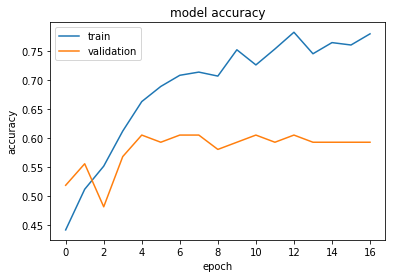

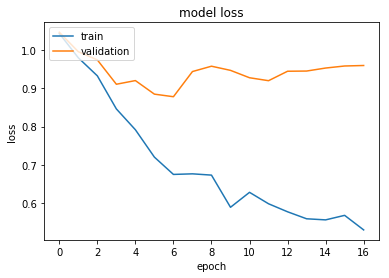

Time passed for training 94.46470785140991
train_indices[:5] [0 1 2 3 4] train_indices[-5:] [805 806 807 808 809]
val_indices[:5] [12 27 30 36 72] val_indices[-5:] [751 754 765 767 798]

                                             caption  label
0           two acorns lying ground next oak leaves.      0
1  ruined walls church backdrop white clouds blue...      0
2  man free fall attached blue bungee jumping app...      0
3  falling man attached bungee jumping apparatus....      0
4  man kneeling front tent two similar-looking gi...      1
class_to_index {0: 0, 1: 1, -1: 2}
index_to_class {0: 0, 1: 1, 2: -1}

TRAIN size: 729 	 VAL size: 81
Train label distribution:  label
-1    131
 0    344
 1    254
Name: label, dtype: int64
Val label distribution:  label
-1    16
 0    34
 1    31
Name: label, dtype: int64
Train on 729 samples, validate on 81 samples
Epoch 1/100
729/729 [==============================] - 6s 8ms/step - loss: 1.0490 - acc: 0.4280 - f1: 0.1205 - recall: 0.0837 - preci

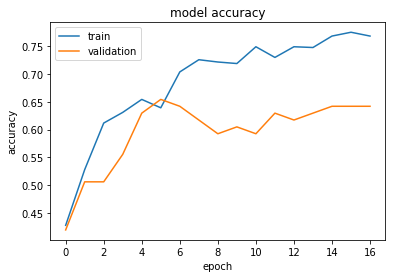

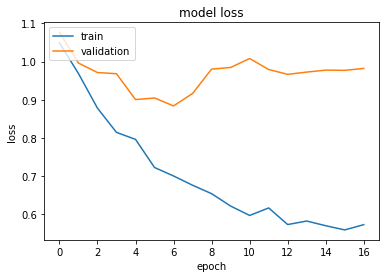

Time passed for training 95.61643195152283
train_indices[:5] [0 1 2 3 4] train_indices[-5:] [805 806 807 808 809]
val_indices[:5] [40 51 54 58 67] val_indices[-5:] [750 763 787 788 793]

                                             caption  label
0           two acorns lying ground next oak leaves.      0
1  ruined walls church backdrop white clouds blue...      0
2  man free fall attached blue bungee jumping app...      0
3  falling man attached bungee jumping apparatus....      0
4  man kneeling front tent two similar-looking gi...      1
class_to_index {0: 0, 1: 1, -1: 2}
index_to_class {0: 0, 1: 1, 2: -1}

TRAIN size: 730 	 VAL size: 80
Train label distribution:  label
-1    133
 0    340
 1    257
Name: label, dtype: int64
Val label distribution:  label
-1    14
 0    38
 1    28
Name: label, dtype: int64
Train on 730 samples, validate on 80 samples
Epoch 1/100
730/730 [==============================] - 6s 8ms/step - loss: 1.0352 - acc: 0.4521 - f1: 0.0807 - recall: 0.0493 - preci

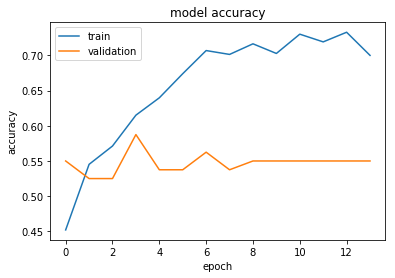

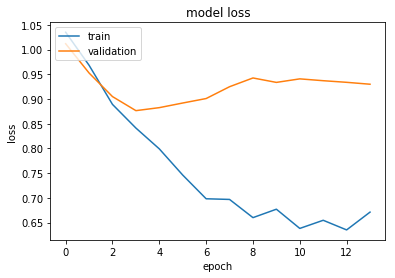

Time passed for training 80.71484088897705
train_indices[:5] [0 1 3 4 5] train_indices[-5:] [804 805 806 807 809]
val_indices[:5] [ 2 18 21 33 41] val_indices[-5:] [789 790 802 803 808]

                                             caption  label
0           two acorns lying ground next oak leaves.      0
1  ruined walls church backdrop white clouds blue...      0
3  falling man attached bungee jumping apparatus....      0
4  man kneeling front tent two similar-looking gi...      1
5  group young students classroom knees hands fol...      0
class_to_index {0: 0, 1: 1, -1: 2}
index_to_class {0: 0, 1: 1, 2: -1}

TRAIN size: 731 	 VAL size: 79
Train label distribution:  label
-1    126
 0    342
 1    263
Name: label, dtype: int64
Val label distribution:  label
-1    21
 0    36
 1    22
Name: label, dtype: int64
Train on 731 samples, validate on 79 samples
Epoch 1/100
731/731 [==============================] - 6s 9ms/step - loss: 1.0383 - acc: 0.4268 - f1: 0.0449 - recall: 0.0260 - preci

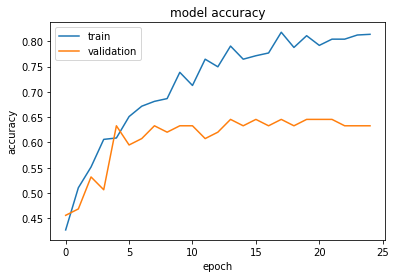

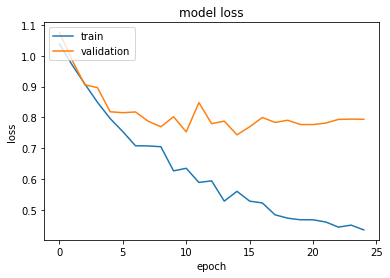

Time passed for training 138.022358417511
train_indices[:5] [0 1 2 3 4] train_indices[-5:] [803 805 806 808 809]
val_indices[:5] [23 29 31 37 38] val_indices[-5:] [770 780 794 804 807]

                                             caption  label
0           two acorns lying ground next oak leaves.      0
1  ruined walls church backdrop white clouds blue...      0
2  man free fall attached blue bungee jumping app...      0
3  falling man attached bungee jumping apparatus....      0
4  man kneeling front tent two similar-looking gi...      1
class_to_index {0: 0, 1: 1, -1: 2}
index_to_class {0: 0, 1: 1, 2: -1}

TRAIN size: 731 	 VAL size: 79
Train label distribution:  label
-1    141
 0    338
 1    252
Name: label, dtype: int64
Val label distribution:  label
-1     6
 0    40
 1    33
Name: label, dtype: int64
Train on 731 samples, validate on 79 samples
Epoch 1/100
731/731 [==============================] - 6s 9ms/step - loss: 1.0573 - acc: 0.4378 - f1: 0.0605 - recall: 0.0369 - precis

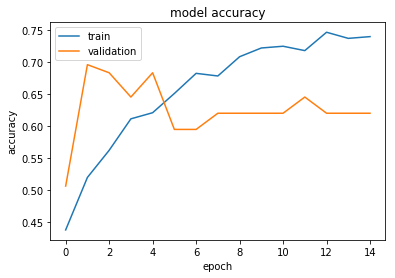

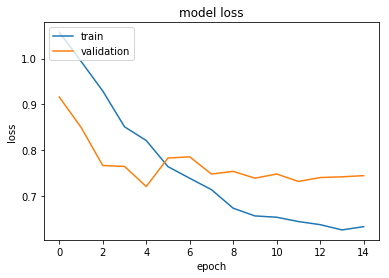

Time passed for training 87.51769924163818
Cross-validation val accuracy results:  [0.6707317073170732, 0.6951219512195121, 0.7073170731707317, 0.6341463414634146, 0.6951219512195121, 0.6049382716049383, 0.654320987654321, 0.5875, 0.6455696247800996, 0.6962025339090372]
Cross-validation val accuracy results: 0.66% (+/- 0.04%)

 Cross-validation val f1 results:  [0.6535273514142851, 0.6518524783413585, 0.6723314392857436, 0.6061115366656605, 0.68796400907563, 0.5971050829063227, 0.6066511354328673, 0.5372264921665192, 0.657656118839602, 0.6439891336839411]
Cross-validation val f1 results: 0.63% (+/- 0.04%)
filenames:  ['Alcohol 7.jpg' 'Bungee jumping 3.jpg' 'Camping 3.jpg' 'Camping 8.jpg'
 'Camping 9.jpg' 'Car accident 1.jpg' 'Child labor 1.jpg' 'Coffee 1.jpg'
 'Cold 7.jpg' 'Couple 4.jpg' 'Couple 8.jpg' 'Crosswalk 1.jpg' 'Cups 1.jpg'
 'Cups 4.jpg' 'Dancing 7.jpg' 'Dead bodies 3.jpg' 'Depressed pose 3.jpg'
 'Dessert 3.jpg' 'Doctor 3.jpg' 'Dog 3.jpg' 'Dog 6.jpg' 'Dog 11.jpg'
 'Dog 19.jpg'

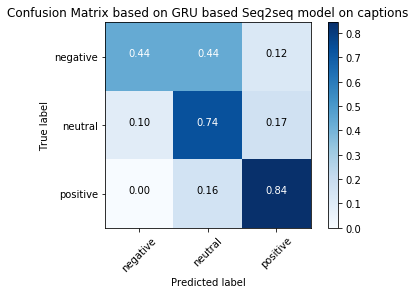

three men two women dressed medieval costumes sit benches wooden table. table horn, furred hat, apple it. shield nearby. TL 1 PL 0
three boys playing refugee camp tents behind them. TL 0 PL 1
group male workers, mostly children factory. TL 0 PL 1
leafless tree, covered snow. ground tree also covered snow, tracks seen right tree. TL 1 PL 0
three girls ring holding hands. outdoors. brown skin straight black hair. TL 1 PL 0
black white photo woman sitting ground one hand face top head. TL -1 PL 0
brown dog paws nose fence looking it. TL -1 PL 1
pasta salad olives tomatoes TL 0 PL -1
several containers raspberries. TL 1 PL 0
man holding head hands. TL -1 PL 0
man walks amidst crosses marking graves cemetery. TL -1 PL 0
sunset small cemetery. TL 0 PL 1
weasel sitting upright like human being. TL 0 PL -1
boy sitting couch head sunk arms crossed tops drawn-up knees. TL -1 PL 0
two women dressed leather, one bright red hair, black, sitting backs kneeling men. red-haired woman sits man full blu

In [7]:
def build_model(max_seq_len, num_of_classes, config): 
    # Cross-validation results: 0.61% (+/- 0.13%)
    model = Sequential()
    model.add(Masking(mask_value=0., input_shape=(None, config['embedding_dimension'])))
    model.add(LSTM(max_seq_len, return_sequences=True, dropout=config['dropout'], recurrent_dropout=config['recurrent_dropout'])) 
    model.add(LSTM(max_seq_len, dropout=config['dropout'], recurrent_dropout=config['recurrent_dropout'])) 
    model.add(Dense(num_of_classes, activation='softmax'))
    
    if config['useF1Score']:
        metrics = ['accuracy', sc.f1, sc.recall, sc.precision]
    else:
        metrics = ['accuracy']
    model.compile(loss='categorical_crossentropy', optimizer='adam', 
                      metrics=metrics)
    #print(model.summary())
    return model




def old_evalaute_on_test_data(model, testDataset, inputDataset, wordToVec, config):
    print("filenames: ", testDataset['image_name'].values)
    max_seq_len = int(testDataset['caption'].map(lambda x: caput.get_non_stop_word_count(x.split())).max())
    print("max_seq_len", max_seq_len)
    num_of_classes, class_to_index, index_to_class = caput.get_label_map_from_train_set(inputDataset, wordToVec, max_seq_len, config)
    X_test, y_test_index, _, _, _  = caput.load_dataset_StratifiedKFold(testDataset,wordToVec,max_seq_len,class_to_index, index_to_class, config)
    y_test = caput.convert_index_to_one_hot(y_test_index, num_of_classes) 
    print(model.summary())
    results = model.evaluate(X_test, y_test, verbose=1) # batch_size=1,
    print(model.metrics_names, results)
        
    predictions = model.predict(X_test, verbose=1)    
    print("predictions:\n",predictions)
    print("\n")
    print("class_to_index:", class_to_index)
    print("index_to_class:", index_to_class)
    predictionClasses = imut.conver_predictions_to_classes(predictions, class_to_index)
    y_test_classes = [index_to_class[k] for k in y_test_index]
    y_true = y_test_classes
    print("y_true:\n", y_true)
    print("\n")
    y_pred = predictionClasses
    print("y_pred:\n", y_pred)
    
    
    cnf_matrix = confusion_matrix(y_true, y_pred)
    print("cnf_matrix", cnf_matrix)
    titleOfConfusionMatrix = "Confusion Matrix based on GRU based Seq2seq model on captions"
    pt.plot_confusion_matrix_from_labels(y_true, y_pred, titleOfConfusionMatrix)
    misLabeledCount = 0
    for index, row in testDataset.iterrows():
        caption = row['caption']
        label = row['label']
        if label != y_true[index]:
            print(caption)
            raise "Unexpected result, truth labels should have matched, seems the order is messed up"
        if label != y_pred[index]:
            print(caption,"TL", label,"PL", y_pred[index])
            misLabeledCount += 1 
    print("\n")
    print("Mislabeled count: ", misLabeledCount)


def evalaute_on_test_data(model, testDataset, inputDataset, wordToVec, config):
    print("filenames: ", testDataset['image_name'].values)
    max_seq_len = int(testDataset['caption'].map(lambda x: caput.get_non_stop_word_count(x.split())).max())
    print("max_seq_len", max_seq_len)
    #num_of_classes, class_to_index, index_to_class = caput.get_label_map_from_train_set(inputDataset, wordToVec, max_seq_len, config)
    class_to_index = {}
    index_to_class = {}
    _, _, num_of_classes, class_to_index, index_to_class,_ = caput.load_dataset_StratifiedKFold(
                                                                inputDataset,
                                                                wordToVec, 
                                                                max_seq_len, 
                                                                class_to_index, 
                                                                index_to_class,
                                                                config)
    
    X_test, y_test_index, _, _, _,filenames  = caput.load_dataset_StratifiedKFold(testDataset,wordToVec,max_seq_len,class_to_index, index_to_class, config)
    y_test = caput.convert_index_to_one_hot(y_test_index, num_of_classes) 
    print(model.summary())
    
    print("class_to_index", class_to_index)
    print("index_to_class", index_to_class)
    
    results = model.evaluate(X_test, y_test, verbose=1) # batch_size=1,
    print(model.metrics_names, results)
    predictions = []
    imgToPrediction = {}
    for x_test, image_name in zip(X_test, filenames):
        prediction = model.predict(np.array([x_test]),batch_size=1, verbose=0)[0]    
        #print(image_name,prediction)
        predictions.append(prediction)
        imgToPrediction[image_name] = prediction
        
    predictions = np.array(predictions)
    #predictions = model.predict(X_test, verbose=1)    
    #print("predictions:\n",predictions)
    print("\n")
    print("class_to_index:", class_to_index)
    print("index_to_class:", index_to_class)
    predictionClasses = imut.conver_predictions_to_classes(predictions, class_to_index)
    y_test_classes = [index_to_class[k] for k in y_test_index]
    y_true = y_test_classes
    print("y_true:\n", y_true)
    print("\n")
    y_pred = predictionClasses
    print("y_pred:\n", y_pred)
    
    
    cnf_matrix = confusion_matrix(y_true, y_pred)
    print("cnf_matrix", cnf_matrix)
    titleOfConfusionMatrix = "Confusion Matrix based on GRU based Seq2seq model on captions"
    pt.plot_confusion_matrix_from_labels(y_true, y_pred, titleOfConfusionMatrix)
    misLabeledCount = 0
    for index, row in testDataset.iterrows():
        caption = row['caption']
        label = row['label']
        if label != y_true[index]:
            print(caption)
            raise "Unexpected result, truth labels should have matched, seems the order is messed up"
        if label != y_pred[index]:
            print(caption,"TL", label,"PL", y_pred[index])
            misLabeledCount += 1 
    print("\n")
    print("Mislabeled count: ", misLabeledCount)
    print("\n")
    print("imgToPrediction=",imgToPrediction)    
    
    
def train_StratifiedKFold(inputDataset, testDataset, wordToVec, config):
    """StratifiedKFold cross-validation"""
    # Shuffle dataset
    df = shuffle(inputDataset)
    X = df["caption"]
    y = df["label"]
    print("Label distribution: ",df.groupby('label').label.count())
    max_seq_len = int(df['caption'].map(lambda x: caput.get_non_stop_word_count(x.split())).max())
    print("max_seq_len", max_seq_len)
    
    # Instantiate the cross validator
    skf = StratifiedKFold(n_splits=kfold_splits, shuffle=True)
    cv_accuracies = []
    cv_f1s = []
    
    best_model = None
    best_model_best_acc = -1
    
    # Loop through the indices the split() method returns
    for index, (train_indices, val_indices) in enumerate(skf.split(X, y)):
        print("train_indices[:5]", train_indices[:5],"train_indices[-5:]",train_indices[-5:])
        print("val_indices[:5]", val_indices[:5],"val_indices[-5:]",val_indices[-5:])
        print()
        
        
        start = time.time()        
        class_to_index = {}
        index_to_class = {}
        
        X_train_caption, X_val_caption = X[train_indices], X[val_indices]
        y_train_index, y_val_index = y[train_indices], y[val_indices]
        
        dfTrain = pd.concat([X_train_caption, y_train_index], axis=1)
        dfTrain.columns = ['caption', 'label']
        
        print(dfTrain.head())
        
        X_train, y_train_index, num_of_classes, class_to_index, index_to_class,_ = \
            caput.load_dataset_StratifiedKFold(
                            dfTrain,
                            wordToVec, 
                            max_seq_len, 
                            class_to_index, 
                            index_to_class,
                            config)
        y_train = caput.convert_index_to_one_hot(y_train_index, num_of_classes) 
        
#         y_ints = [y.argmax() for y in y_train]
#         class_weights = class_weight.compute_class_weight('balanced',
#                                                  np.unique(y_ints),
#                                                  y_ints)
#         print("class_weights", class_weights)
        print("class_to_index", class_to_index)
        print("index_to_class", index_to_class)
        
        dfVal= pd.concat([X_val_caption, y_val_index], axis=1)
        dfVal.columns = ['caption', 'label']
        X_val, y_val_index, _, _, _, _ = caput.load_dataset_StratifiedKFold(
                            dfVal,
                            wordToVec,
                            max_seq_len, 
                            class_to_index, 
                            index_to_class,
                            config)
        y_val = caput.convert_index_to_one_hot(y_val_index, num_of_classes) 
        
        
        print("\nTRAIN size:", len(train_indices), "\t VAL size:", len(val_indices))
        print("Train label distribution: ",dfTrain.groupby('label').label.count())
        print("Val label distribution: ",dfVal.groupby('label').label.count())

        
        model = build_model(max_seq_len,num_of_classes, config)
        
        plot_model(model, to_file = model_results_root_dir + '/model.png', show_shapes=True, show_layer_names=True)#
        
        
        # Log to tensorboard
        tensorBoardCallback = TensorBoard(log_dir=model_results_root_dir + '/logs', write_graph=True)
        
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                                  factor=0.5, 
                                  patience=2, 
                                  min_lr=1e-7,
                                  cooldown=1,
                                  verbose=1)
        
        history = {}
        filename = ""
        # checkpoint
        filepath= model_results_root_dir + "/weights.best.h5"
        checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
        early_stopping = EarlyStopping(monitor='val_loss', patience=patience)
        
        callbacks_list = [checkpoint,  reduce_lr, early_stopping, tensorBoardCallback]  # 
        
        history = model.fit(x=X_train,
                      y=y_train, 
                      batch_size=config['batch_size'],
                      epochs=config['nb_epochs'], 
                      verbose=config['verbose'], 
                      validation_data = (X_val, y_val),
                      shuffle=True,
                      callbacks=callbacks_list)        # 
        val_acc_list = history.history['val_acc']
        best_val_acc =  max(val_acc_list)
        cv_accuracies.append(best_val_acc)
        print("best_val_acc: ", best_val_acc)
        
        if config['useF1Score']:
            val_f1_list = history.history['val_f1']
            best_f1 =  max(val_f1_list)
            print("best_f1: ", best_f1)
            cv_f1s.append(best_f1)
        
        filename = "caption" 
        filename = model_results_root_dir + caput.generate_model_name(filename, best_val_acc) + ".h5"
        os.rename(filepath, filename)
        
        pt.plot_model_accuracy(history,model_results_root_dir, config['useF1Score'])
        
        end = time.time()
        print("Time passed for training", (end-start))
        
        if best_val_acc > best_model_best_acc:
            best_model_best_acc = best_val_acc
            best_model = model
    
    print("=========================================")
    print("Cross-validation val accuracy results: " , cv_accuracies)
    print("Cross-validation val accuracy results: %.2f%% (+/- %.2f%%)" % (np.mean(cv_accuracies), np.std(cv_accuracies)))
    
    print("\n","Cross-validation val f1 results: " , cv_f1s)
    print("Cross-validation val f1 results: %.2f%% (+/- %.2f%%)" % (np.mean(cv_f1s), np.std(cv_f1s)))
    
    best_model.save(model_results_root_dir + "/bestmodel-" + str(best_model_best_acc) + ".h5")
    return best_model


def get_config():
    conf = {}
    conf["kfold_splits"] = kfold_splits
    conf["batch_size"] = batch_size
    conf['embedding_dimension'] = embedding_dimension
    conf['recurrent_dropout'] = recurrent_dropout
    conf['dropout'] = dropout
    conf["nb_epochs"] = nb_epochs
    conf['useF1Score'] = useF1Score
    conf['verbose'] = verbose
    conf['useF1Score'] = useF1Score
    conf['seed'] = seed
    return conf    
    
best_model = None
def main():
    global wordToVec, best_model
    config = get_config()
    print("config:\n", config)
    if wordToVec is None:
        wordToVec = load_embedding(fasttext_embedding_path)
    print("# words: ", len(wordToVec.keys())," word vector dimension", len(wordToVec[list(wordToVec.keys())[1]]))
    best_model = train_StratifiedKFold(inputDataset, testDataset, wordToVec, config)
    # Evaluate Test data set
    evalaute_on_test_data(best_model, testDataset, inputDataset, wordToVec, config)
    

if __name__ == "__main__":
    # execute only if run as a script
    main()
    pass

## Evaluating test dataset

In [8]:
from keras.models import load_model
best_model_path = model_results_root_dir + "bestmodel-0.7682926829268293.h5" 
custom_objects={'f1': sc.f1, 'recall': sc.recall, 'precision': sc.precision}
model = load_model(best_model_path, custom_objects)
print(model.summary())

OSError: Unable to open file (unable to open file: name = 'model2/bestmodel-0.7682926829268293.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
def evalaute_on_test_data(model, testDataset, inputDataset, wordToVec, config):
    print("filenames: ", testDataset['image_name'].values)
    max_seq_len = int(testDataset['caption'].map(lambda x: caput.get_non_stop_word_count(x.split())).max())
    print("max_seq_len", max_seq_len)
    #num_of_classes, class_to_index, index_to_class = caput.get_label_map_from_train_set(inputDataset, wordToVec, max_seq_len, config)
    class_to_index = {}
    index_to_class = {}
    _, _, num_of_classes, class_to_index, index_to_class,_ = caput.load_dataset_StratifiedKFold(
                                                                inputDataset,
                                                                wordToVec, 
                                                                max_seq_len, 
                                                                class_to_index, 
                                                                index_to_class,
                                                                config)
    
    X_test, y_test_index, _, _, _,filenames  = caput.load_dataset_StratifiedKFold(testDataset,wordToVec,max_seq_len,class_to_index, index_to_class, config)
    y_test = caput.convert_index_to_one_hot(y_test_index, num_of_classes) 
    print(model.summary())
    
    print("class_to_index", class_to_index)
    print("index_to_class", index_to_class)
    
    results = model.evaluate(X_test, y_test, verbose=1) # batch_size=1,
    print(model.metrics_names, results)
    predictions = []
    imgToPrediction = {}
    for x_test, image_name in zip(X_test, filenames):
        prediction = model.predict(np.array([x_test]),batch_size=1, verbose=0)[0]    
        #print(image_name,prediction)
        predictions.append(prediction)
        imgToPrediction[image_name] = prediction
        
    predictions = np.array(predictions)
    #predictions = model.predict(X_test, verbose=1)    
    #print("predictions:\n",predictions)
    print("\n")
    print("class_to_index:", class_to_index)
    print("index_to_class:", index_to_class)
    predictionClasses = imut.conver_predictions_to_classes(predictions, class_to_index)
    y_test_classes = [index_to_class[k] for k in y_test_index]
    y_true = y_test_classes
    print("y_true:\n", y_true)
    print("\n")
    y_pred = predictionClasses
    print("y_pred:\n", y_pred)
    
    
    cnf_matrix = confusion_matrix(y_true, y_pred)
    print("cnf_matrix", cnf_matrix)
    titleOfConfusionMatrix = "Confusion Matrix based on GRU based Seq2seq model on captions"
    pt.plot_confusion_matrix_from_labels(y_true, y_pred, titleOfConfusionMatrix)
    misLabeledCount = 0
    for index, row in testDataset.iterrows():
        caption = row['caption']
        label = row['label']
        if label != y_true[index]:
            print(caption)
            raise "Unexpected result, truth labels should have matched, seems the order is messed up"
        if label != y_pred[index]:
            print(caption,"TL", label,"PL", y_pred[index])
            misLabeledCount += 1 
    print("\n")
    print("Mislabeled count: ", misLabeledCount)
    print("\n")
    print("imgToPrediction=",imgToPrediction)
    
evalaute_on_test_data(model, testDataset, inputDataset, wordToVec, get_config())    

In [ ]:
testDataset.head()